# Driver Behavior Dataset

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wandb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [143]:
def get_event(seconds_passed, groundTruth):
    for _, row in groundTruth.iterrows():
        if row[' inicio'] <= seconds_passed <= row[' fim']:
            return row['evento']
    return None

In [144]:
def getGroundTruth(df, groundTruth_orig):
    df['seconds_passed'] = (df['uptimeNanos'] - df['uptimeNanos'].iloc[0]) / 1e9 # Converting timestamp to seconds passed
    df['evento'] = df['seconds_passed'].apply(lambda x: get_event(x, groundTruth_orig)) # Getting the event for each row based on seconds passed
    return df


In [145]:
def getData(driver):
    accLinear_orig = pd.read_csv(f'data/{driver}/aceleracaoLinear_terra.csv')
    acelerometro_orig = pd.read_csv(f'data/{driver}/acelerometro_terra.csv')
    giroscopio_orig = pd.read_csv(f'data/{driver}/giroscopio_terra.csv')
    groundTruth_orig = pd.read_csv(f'data/{driver}/groundTruth.csv')

    # Renaming columns to avoid conflicts
    accLinear = accLinear_orig.rename(columns={'x': 'x_accLinear', 'y': 'y_accLinear', 'z': 'z_accLinear'}, inplace=False) 
    acelerometro = acelerometro_orig.rename(columns={'x': 'x_acelerometro', 'y': 'y_acelerometro', 'z': 'z_acelerometro'}, inplace=False) 
    giroscopio = giroscopio_orig.rename(columns={'x': 'x_giroscopio', 'y': 'y_giroscopio', 'z': 'z_giroscopio'}, inplace=False)

    # Merging all dataframes
    df = pd.concat([accLinear, acelerometro, giroscopio], axis=1)
    df = df.loc[:, ~df.columns.duplicated()]

    # Converting timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y %H:%M:%S')
    # Getting the event for each row based on seconds passed
    df = getGroundTruth(df, groundTruth_orig)

    # Changing Nones to 'sem_evento'
    df['evento'] = df['evento'].fillna('sem_evento')

    return df

In [5]:
df_16 = getData(16)
df_17 = getData(17)
df_20 = getData(20)
df_21 = getData(21)

In [17]:
data = [df_16, df_17, df_20, df_21]
cols = ['timestamp', 'uptimeNanos']
for i in range(len(data)):
    data[i] = data[i].drop(cols, axis=1, inplace=False)

Plotting different sensors to see the difference

In [18]:
def plot_sensor_data(data, sensor=None, figsize=(10, 4), begin=None, end=None):
    if begin is not None:
        data = data[data['seconds_passed'] >= begin]
        if end < begin:
            raise ValueError('End must be greater than begin')

    if end is not None:
        data = data[data['seconds_passed'] <= end]

    if sensor is None:
        sensor = ['acelerometro', 'accLinear', 'giroscopio']
    
    plt.figure(figsize=figsize)
    plt.plot(data['seconds_passed'], data[f'x_{sensor}'], label=f'x_{sensor}')
    plt.plot(data['seconds_passed'], data[f'y_{sensor}'], label=f'y_{sensor}')
    plt.plot(data['seconds_passed'], data[f'z_{sensor}'], label=f'z_{sensor}')
    
    # Highlight regions where 'evento' is not 'sem_evento'
    highlight_color = 'lightgrey'  # Use the same color for all events

    for i in range(len(data) - 1):
        if data['evento'].iloc[i] != 'sem_evento':
            plt.axvspan(data['seconds_passed'].iloc[i], data['seconds_passed'].iloc[i + 1], 
                        alpha=0.3, color=highlight_color, edgecolor='none')
            if i == 0 or data['evento'].iloc[i] != data['evento'].iloc[i - 1]:
                plt.text((data['seconds_passed'].iloc[i] + data['seconds_passed'].iloc[i + 1]) / 2, 
                         max(data[f'x_{sensor}'].max(), data[f'y_{sensor}'].max(), data[f'z_{sensor}'].max()), 
                         data['evento'].iloc[i], 
                         horizontalalignment='left', 
                         verticalalignment='top', 
                         fontsize=12, 
                         color='black', 
                         rotation=0)

    plt.xlabel('Uptime (seconds)')
    plt.ylabel(sensor.capitalize())
    plt.legend()
    plt.xticks(range(int(data['seconds_passed'].min()), int(data['seconds_passed'].max()) + 1))
    plt.show()


In [ ]:
plot_sensor_data(df_21, 'giroscopio', figsize=(25, 4), begin=0, end=50)

### Sliding Windows

In [146]:
def get_features(window):
    # Features such as mean, max, min and std from the window
    features = np.array([])
    features = np.append(features, [window.mean(), window.max(), window.min(), window.std(), window.max() - window.min()])
    return features

In [147]:
def create_sliding_windows(data, window_size=7, step_size=1):
    X = []
    y = []
    # splits = np.zeros(len(data))
    cont = 0
    for k in range(len(data)):
        for i in range(0, len(data[k]) - window_size + 1, step_size):
            end = i + window_size

            if end > len(data[k]):
                end = len(data[k])

            if data[k]['evento'][i] == 'sem_evento':
                continue
            if data[k]['evento'][end - 1] == 'sem_evento':
                continue
            
            window_label = data[k]['evento'][i] # Getting the most frequent event in the window
            window = data[k][i:end].drop(['evento', 'seconds_passed'], axis=1, inplace=False) # Dropping 'evento' and 'seconds_passed' columns
            features = get_features(window) # Getting features from the window

            if len(window) < window_size:
                padding = np.zeros((window_size - len(window), len(window.columns))) # Padding the window with zeros and the same amount of columns
                window = np.vstack([window, padding]) # Stacking the window and padding keeping the same order

            window = np.append(window.to_numpy().flatten(), features) # Flattening the window and appending the features
            X.append(window)
            y.append(window_label)

        # splits[k] = cont

    return np.array(X), np.array(y)

In [148]:
def get_unique_counts(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

In [149]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test  

In [150]:
window_size = 7
step_size = 1
X, y = create_sliding_windows(data, window_size, step_size) # This will create the sliding windows with a 3D X and 1D y
X.shape, y.shape

((10663, 108), (10663,))

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Since we already have windows with labels, we can split the data into train and test sets

In [152]:
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

In [153]:
classes = np.unique(y_train)
one_hot = {}
for i in range(len(classes)):
    one_hot[classes[i]] = i
y_train_one_hot = np.array([one_hot[i] for i in y_train])
y_test_one_hot = np.array([one_hot[i] for i in y_test])
one_hot

{'aceleracao_agressiva': 0,
 'curva_direita_agressiva': 1,
 'curva_esquerda_agressiva': 2,
 'evento_nao_agressivo': 3,
 'freada_agressiva': 4,
 'troca_faixa_direita_agressiva': 5,
 'troca_faixa_esquerda_agressiva': 6}

Veryfing the balance of the split

In [154]:
print('Train set:', get_unique_counts(y_train))
print('Test set:', get_unique_counts(y_test))

Train set: {'aceleracao_agressiva': 1716, 'curva_direita_agressiva': 1495, 'curva_esquerda_agressiva': 1515, 'evento_nao_agressivo': 1964, 'freada_agressiva': 1081, 'troca_faixa_direita_agressiva': 440, 'troca_faixa_esquerda_agressiva': 319}
Test set: {'aceleracao_agressiva': 414, 'curva_direita_agressiva': 387, 'curva_esquerda_agressiva': 365, 'evento_nao_agressivo': 480, 'freada_agressiva': 309, 'troca_faixa_direita_agressiva': 94, 'troca_faixa_esquerda_agressiva': 84}


# Machine Learning

First, let's try directly applying a RF algorithm using a single drive to see what happens

In [155]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [156]:
reports = {}

## Random Forest Classifier

Creating and training the classifier

In [157]:
def fit_RF(X_train, X_test, y_train, y_test, n_estimators=100, random_state=42):
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, classification_report(y_test, y_pred), y_pred

Model Fitting

In [88]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, verbose=5, n_jobs=-1)
best_params_rf = grid_search.fit(X_train_scaled, y_train).best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 4/5] END ...................n_estimators=50;, score=0.933 total time=   3.8s
[CV 5/5] END ...................n_estimators=50;, score=0.950 total time=   4.1s
[CV 2/5] END ...................n_estimators=50;, score=0.949 total time=   4.7s
[CV 3/5] END ...................n_estimators=50;, score=0.944 total time=   4.7s
[CV 1/5] END ...................n_estimators=50;, score=0.934 total time=   4.6s
[CV 4/5] END ..................n_estimators=100;, score=0.943 total time=   7.8s
[CV 2/5] END ..................n_estimators=100;, score=0.953 total time=   9.1s
[CV 5/5] END ..................n_estimators=100;, score=0.954 total time=  10.4s
[CV 3/5] END ..................n_estimators=100;, score=0.949 total time=  11.5s
[CV 1/5] END ..................n_estimators=100;, score=0.937 total time=  12.1s
[CV 2/5] END ..................n_estimators=200;, score=0.953 total time=  26.4s
[CV 1/5] END ..................n_estimators=200;,

In [158]:
# Non scaled data
print(best_params_rf)
clf, report, y_pred = fit_RF(X_train, X_test, y_train, y_test, **best_params_rf)
reports['Random Forest'] = report

{'n_estimators': 300}


In [159]:
print(f"Classification report:\n{report}")

Classification report:
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.94      0.98      0.96       414
       curva_direita_agressiva       0.96      1.00      0.98       387
      curva_esquerda_agressiva       0.98      0.99      0.99       365
          evento_nao_agressivo       0.93      0.94      0.94       480
              freada_agressiva       0.99      0.95      0.97       309
 troca_faixa_direita_agressiva       1.00      0.84      0.91        94
troca_faixa_esquerda_agressiva       0.99      0.82      0.90        84

                      accuracy                           0.96      2133
                     macro avg       0.97      0.93      0.95      2133
                  weighted avg       0.96      0.96      0.96      2133



In [160]:
def display_cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

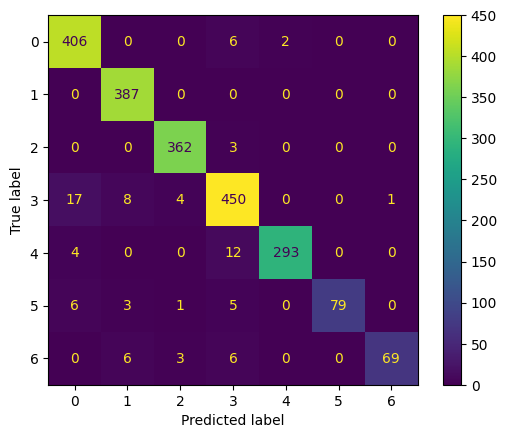

In [161]:
display_cm(y_test, y_pred)

Clearly, scaling the data does not seem to help the Random Forest Classifier

## SVC (Support Vector Classifier)

In [162]:
from sklearn.svm import SVC

In [163]:
def fit_SVC(X_train, X_test, y_train, y_test, C=100, gamma=0.1, kernel='rbf'):
    clf = SVC(C=C, gamma=gamma, kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return clf, classification_report(y_test, y_pred), y_pred

Hyperparameter search

In [97]:
param_grid = {'C': [1, 10, 100], 'gamma': [0.1, 0.01], 'kernel': ['rbf']} # Defining the hyperparameters to be tested

In [98]:
grid_search = GridSearchCV(SVC(), param_grid, verbose=3, n_jobs=-1) # Creating the GridSearchCV object
grid_search.fit(X_train_scaled, y_train) # Fitting the model
best_params_svc = grid_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.908 total time=   5.4s
[CV 4/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.877 total time=   5.8s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.902 total time=   6.7s
[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.883 total time=   7.1s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.879 total time=   7.2s
[CV 2/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.936 total time=   6.4s
[CV 1/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.835 total time=  16.7s
[CV 1/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.926 total time=  11.0s
[CV 3/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.941 total time=   5.2s
[CV 4/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.930 total time=   8.7s
[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.803 total time=  25.5s
[CV 5/5] END ......C=10, gamma=0.01, kernel=rbf;,

In [100]:
print(best_params_svc)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


Model training

In [164]:
svc_model, svc_report, y_svc_pred = fit_SVC(X_train_scaled, X_test_scaled, y_train, y_test, **best_params_svc)
print(f"Classification report (SVC scaled):\n{svc_report}")
reports['SVC'] = svc_report

svc_model_scaled, svc_report_scaled, y_svc_pred_scaled = fit_SVC(X_train, X_test, y_train, y_test, **best_params_svc)
print(f"Classification report (SVC non-scaled):\n{svc_report_scaled}")

Classification report (SVC scaled):
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.94      0.94      0.94       414
       curva_direita_agressiva       0.97      1.00      0.98       387
      curva_esquerda_agressiva       0.99      0.98      0.99       365
          evento_nao_agressivo       0.91      0.94      0.92       480
              freada_agressiva       1.00      0.94      0.97       309
 troca_faixa_direita_agressiva       0.98      0.94      0.96        94
troca_faixa_esquerda_agressiva       0.91      0.85      0.88        84

                      accuracy                           0.96      2133
                     macro avg       0.96      0.94      0.95      2133
                  weighted avg       0.96      0.96      0.96      2133

Classification report (SVC non-scaled):
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.89      0.90     

SVC works better with scaled data

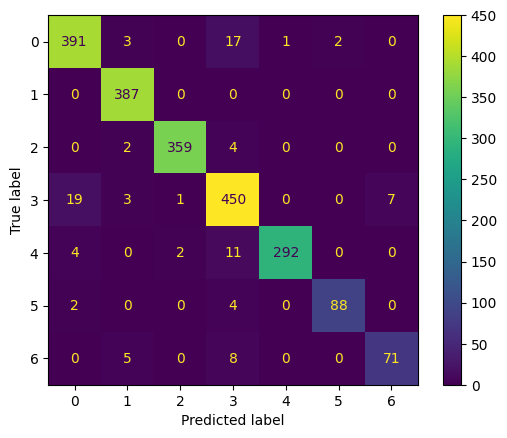

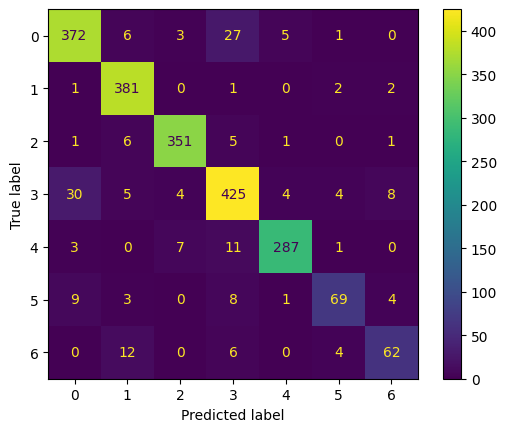

In [165]:
display_cm(y_test, y_svc_pred)
display_cm(y_test, y_svc_pred_scaled)

## XGBoost

In [166]:
from xgboost import XGBClassifier

In [172]:
def fit_XGB(X_train, X_test, y_train, y_test, n_estimators=100, max_depth=4):
    model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, classification_report(y_test, y_pred, target_names=list(one_hot.keys())), y_pred

In [173]:
xgb_model, xgb_report, y_pred_xgb = fit_XGB(X_train_scaled, X_test_scaled, y_train_one_hot, y_test_one_hot, n_estimators=300, max_depth=3)
reports['XGB'] = xgb_report
print(f"**Classification report (XGB):**\n{xgb_report}")

**Classification report (XGB):**
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.97      0.99      0.98       414
       curva_direita_agressiva       0.99      1.00      0.99       387
      curva_esquerda_agressiva       0.99      0.99      0.99       365
          evento_nao_agressivo       0.98      0.97      0.98       480
              freada_agressiva       1.00      0.99      0.99       309
 troca_faixa_direita_agressiva       0.99      0.93      0.96        94
troca_faixa_esquerda_agressiva       0.98      0.94      0.96        84

                      accuracy                           0.98      2133
                     macro avg       0.98      0.97      0.98      2133
                  weighted avg       0.98      0.98      0.98      2133



# MLP Scikit-Learn

In [174]:
from sklearn.neural_network import MLPClassifier

In [175]:
def fit_MLP(X_train, X_test, y_train, y_test, hidden_layer_sizes=(100, 50, 25), max_iter=1000, activation='relu', solver='adam'):
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, activation=activation, solver=solver)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, classification_report(y_test, y_pred), y_pred

In [109]:
mlp, mlp_scikit_report, y_pred_mlp = fit_MLP(X_train_scaled, X_test_scaled, y_train, y_test, hidden_layer_sizes=(500, 250, 100, 50), max_iter=2000, activation='relu', solver='adam')
reports['MLP_Scikit'] = mlp_scikit_report
print(f"**Classification report (MLP):**\n{mlp_scikit_report}")

**Classification report (MLP):**
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.96      0.99      0.98       414
       curva_direita_agressiva       0.99      0.99      0.99       387
      curva_esquerda_agressiva       0.99      1.00      0.99       365
          evento_nao_agressivo       0.97      0.95      0.96       480
              freada_agressiva       0.99      0.99      0.99       309
 troca_faixa_direita_agressiva       0.97      0.90      0.93        94
troca_faixa_esquerda_agressiva       0.94      0.93      0.93        84

                      accuracy                           0.98      2133
                     macro avg       0.97      0.97      0.97      2133
                  weighted avg       0.98      0.98      0.98      2133



# MLP TensorFlow

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Input

In [113]:
def create_model(opmitizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    model =  Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(500, activation='relu'),
        Dropout(0.2),
        LayerNormalization(),
        Dense(250, activation='relu'),
        Dropout(0.2),
        LayerNormalization(),
        Dense(100, activation='relu'),
        Dropout(0.2),
        LayerNormalization(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        LayerNormalization(),
        Dense(len(np.unique(y_train)), activation='softmax')
    ])

    model.compile(optimizer=opmitizer, loss=loss, metrics=metrics)
    return model

In [114]:
def resultados_modelo(historico):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.flatten()

    ax[0].plot(historico.history['accuracy'], label='Accuracy', marker='o', color='red')
    ax[0].plot(historico.history['val_accuracy'], label='Val_Accuracy', marker='o', color='blue')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')

    ax[1].plot(historico.history['loss'], label='Loss', marker='o', color='red')
    ax[1].plot(historico.history['val_loss'], label='Val_Loss', marker='o', color='blue')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')

    for i in range(2):
        ax[i].legend()
        ax[i].grid()

    acc_size =len(historico.history["accuracy"]) - 1
    print(f'Acurácia final: {round(100 * historico.history["accuracy"][acc_size], 3)}%')
    loss_size =len(historico.history["loss"]) - 1
    print(f'Loss final: {round(100 * historico.history["loss"][loss_size], 3)}%')

In [115]:
def train_mlp_wandb():
    wandb.init(project='DriverBehavior')
    epochs = wandb.config.epochs
    batch_size = wandb.config.batch_size

    model = create_model()
    history = model.fit(X_train_scaled, y_train_one_hot, epochs=epochs, batch_size=batch_size, validation_data=(X_test_scaled, y_test_one_hot))

    wandb.log({
        'train_loss': history.history['loss'][-1],
        'train_accuracy': history.history['accuracy'][-1],
        'val_loss': history.history['val_loss'][-1],
        'val_accuracy': history.history['val_accuracy'][-1],
    })

In [66]:
sweep_config = {
    'method': 'grid',  # 'random' or 'bayes' for other strategies
    'metric': {
        'name': 'val_accuracy',  # The metric to optimize
        'goal': 'maximize'  # Maximize or minimize the metric
    },
    'parameters': {
        'epochs': {
            'values': [10, 25, 50]  # Range of epochs to test
        },
        'batch_size': {
            'values': [32, 64, 128]  # Range of batch sizes to test
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="DriverBehavior")

Create sweep with ID: gut8lurp
Sweep URL: https://wandb.ai/renan-florencio-unicamp/DriverBehavior/sweeps/gut8lurp


In [67]:
wandb.agent(sweep_id, train_mlp_wandb, count=10)

wandb: Agent Starting Run: wa0u51qj with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10


Epoch 1/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5708 - loss: 1.2386 - val_accuracy: 0.8401 - val_loss: 0.5023
Epoch 2/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8150 - loss: 0.5633 - val_accuracy: 0.8790 - val_loss: 0.3666
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8610 - loss: 0.4236 - val_accuracy: 0.8955 - val_loss: 0.3012
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8725 - loss: 0.3591 - val_accuracy: 0.9072 - val_loss: 0.2684
Epoch 5/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9073 - loss: 0.2814 - val_accuracy: 0.9198 - val_loss: 0.2360
Epoch 6/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9137 - loss: 0.2591 - val_accuracy: 0.9287 - val_loss: 0.2208
Epoch 7/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9217 - loss: 0.2276 - val_accuracy: 0.9259 - val_loss: 0.2389
Epoch 8/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9198 - loss: 0.2255 - val_accuracy: 0.

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.93916
train_loss,0.16933
val_accuracy,0.94374
val_loss,0.18658


wandb: Agent Starting Run: syfu5ppp with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25


Epoch 1/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5613 - loss: 1.2509 - val_accuracy: 0.8242 - val_loss: 0.4856
Epoch 2/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7947 - loss: 0.5854 - val_accuracy: 0.8837 - val_loss: 0.3256
Epoch 3/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8523 - loss: 0.4223 - val_accuracy: 0.9058 - val_loss: 0.2773
Epoch 4/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8811 - loss: 0.3343 - val_accuracy: 0.9147 - val_loss: 0.2575
Epoch 5/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8941 - loss: 0.2991 - val_accuracy: 0.9287 - val_loss: 0.2127
Epoch 6/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9177 - loss: 0.2408 - val_accuracy: 0.9203 - val_loss: 0.2294
Epoch 7/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9186 - loss: 0.2467 - val_accuracy: 0.9405 - val_loss: 0.1954
Epoch 8/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9275 - loss: 0.2100 - val_accuracy: 0.

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.97257
train_loss,0.08191
val_accuracy,0.9564
val_loss,0.15545


wandb: Agent Starting Run: 0kvkdc3y with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50


Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5555 - loss: 1.2769 - val_accuracy: 0.8448 - val_loss: 0.4363
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8036 - loss: 0.5645 - val_accuracy: 0.8865 - val_loss: 0.3532
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8524 - loss: 0.4331 - val_accuracy: 0.9095 - val_loss: 0.2760
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8849 - loss: 0.3425 - val_accuracy: 0.9208 - val_loss: 0.2443
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9013 - loss: 0.2916 - val_accuracy: 0.9325 - val_loss: 0.1940
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9119 - loss: 0.2587 - val_accuracy: 0.9339 - val_loss: 0.1879
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9281 - loss: 0.2251 - val_accuracy: 0.9311 - val_loss: 0.2079
Epoch 8/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9329 - loss: 0.2002 - val_accuracy: 0.

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.98464
train_loss,0.05015
val_accuracy,0.96906
val_loss,0.14908


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d08g61w2 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10


Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5378 - loss: 1.3229 - val_accuracy: 0.8411 - val_loss: 0.4789
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7916 - loss: 0.6135 - val_accuracy: 0.8800 - val_loss: 0.3742
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8456 - loss: 0.4658 - val_accuracy: 0.8940 - val_loss: 0.3051
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8715 - loss: 0.3706 - val_accuracy: 0.9142 - val_loss: 0.2714
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8868 - loss: 0.3160 - val_accuracy: 0.9194 - val_loss: 0.2285
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9072 - loss: 0.2706 - val_accuracy: 0.9264 - val_loss: 0.2345
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9097 - loss: 0.2654 - val_accuracy: 0.9269 - val_loss: 0.2283
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9226 - loss: 0.2317 - val_accu

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.9381
train_loss,0.18065
val_accuracy,0.93812
val_loss,0.20765


wandb: Agent Starting Run: 3znzxxqe with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25


Epoch 1/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5303 - loss: 1.3739 - val_accuracy: 0.8284 - val_loss: 0.4927
Epoch 2/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7891 - loss: 0.6302 - val_accuracy: 0.8861 - val_loss: 0.3421
Epoch 3/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8476 - loss: 0.4627 - val_accuracy: 0.9062 - val_loss: 0.2701
Epoch 4/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8704 - loss: 0.3736 - val_accuracy: 0.9128 - val_loss: 0.2540
Epoch 5/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8964 - loss: 0.3067 - val_accuracy: 0.9353 - val_loss: 0.2168
Epoch 6/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9021 - loss: 0.2856 - val_accuracy: 0.9301 - val_loss: 0.2212
Epoch 7/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9150 - loss: 0.2466 - val_accuracy: 0.9344 - val_loss: 0.1897
Epoch 8/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9222 - loss: 0.2165 - val_accu

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.97304
train_loss,0.08219
val_accuracy,0.95499
val_loss,0.1595


wandb: Agent Starting Run: fp4pjgab with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50


Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5314 - loss: 1.3547 - val_accuracy: 0.8383 - val_loss: 0.4747
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7909 - loss: 0.6286 - val_accuracy: 0.8758 - val_loss: 0.3519
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8467 - loss: 0.4483 - val_accuracy: 0.8987 - val_loss: 0.3067
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8765 - loss: 0.3713 - val_accuracy: 0.9137 - val_loss: 0.2837
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8964 - loss: 0.3163 - val_accuracy: 0.9142 - val_loss: 0.2376
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9013 - loss: 0.2960 - val_accuracy: 0.9241 - val_loss: 0.2351
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9158 - loss: 0.2411 - val_accuracy: 0.9241 - val_loss: 0.2200
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9256 - loss: 0.2233 - val_accur

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.98124
train_loss,0.05425
val_accuracy,0.97609
val_loss,0.12793


wandb: Agent Starting Run: x95rt9bq with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4989 - loss: 1.4532 - val_accuracy: 0.8228 - val_loss: 0.5362
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7661 - loss: 0.6764 - val_accuracy: 0.8664 - val_loss: 0.4044
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8208 - loss: 0.5339 - val_accuracy: 0.8823 - val_loss: 0.3463
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8493 - loss: 0.4353 - val_accuracy: 0.9109 - val_loss: 0.2698
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8760 - loss: 0.3587 - val_accuracy: 0.9072 - val_loss: 0.2831
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8983 - loss: 0.3140 - val_accuracy: 0.9297 - val_loss: 0.2236
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9082 - loss: 0.2759 - val_accuracy: 0.9278 - val_loss: 0.2219
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9108 - loss: 0.2623 - val_accuracy: 0.9409 - v

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.93189
train_loss,0.20206
val_accuracy,0.93624
val_loss,0.19907


wandb: Agent Starting Run: huhy15vj with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25


Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4712 - loss: 1.5265 - val_accuracy: 0.7979 - val_loss: 0.5860
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7648 - loss: 0.7112 - val_accuracy: 0.8697 - val_loss: 0.3809
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8106 - loss: 0.5406 - val_accuracy: 0.8973 - val_loss: 0.3127
Epoch 4/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8418 - loss: 0.4649 - val_accuracy: 0.9090 - val_loss: 0.2755
Epoch 5/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8810 - loss: 0.3447 - val_accuracy: 0.9161 - val_loss: 0.2475
Epoch 6/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8948 - loss: 0.3079 - val_accuracy: 0.9212 - val_loss: 0.2312
Epoch 7/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8988 - loss: 0.2868 - val_accuracy: 0.9348 - val_loss: 0.2044
Epoch 8/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9161 - loss: 0.2493 - val_accuracy: 0.9325 - v

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.97022
train_loss,0.08487
val_accuracy,0.96296
val_loss,0.13763


wandb: Agent Starting Run: xgjz54bz with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4816 - loss: 1.5145 - val_accuracy: 0.8158 - val_loss: 0.5422
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7641 - loss: 0.6851 - val_accuracy: 0.8805 - val_loss: 0.3798
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8205 - loss: 0.5247 - val_accuracy: 0.8973 - val_loss: 0.3135
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8611 - loss: 0.4233 - val_accuracy: 0.9067 - val_loss: 0.2720
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8782 - loss: 0.3567 - val_accuracy: 0.9203 - val_loss: 0.2335
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8902 - loss: 0.3233 - val_accuracy: 0.9198 - val_loss: 0.2284
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9071 - loss: 0.2794 - val_accuracy: 0.9339 - val_loss: 0.1972
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9188 - loss: 0.2312 - val_accuracy: 0.9395 - v

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.98464
train_loss,0.04612
val_accuracy,0.97656
val_loss,0.10633


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


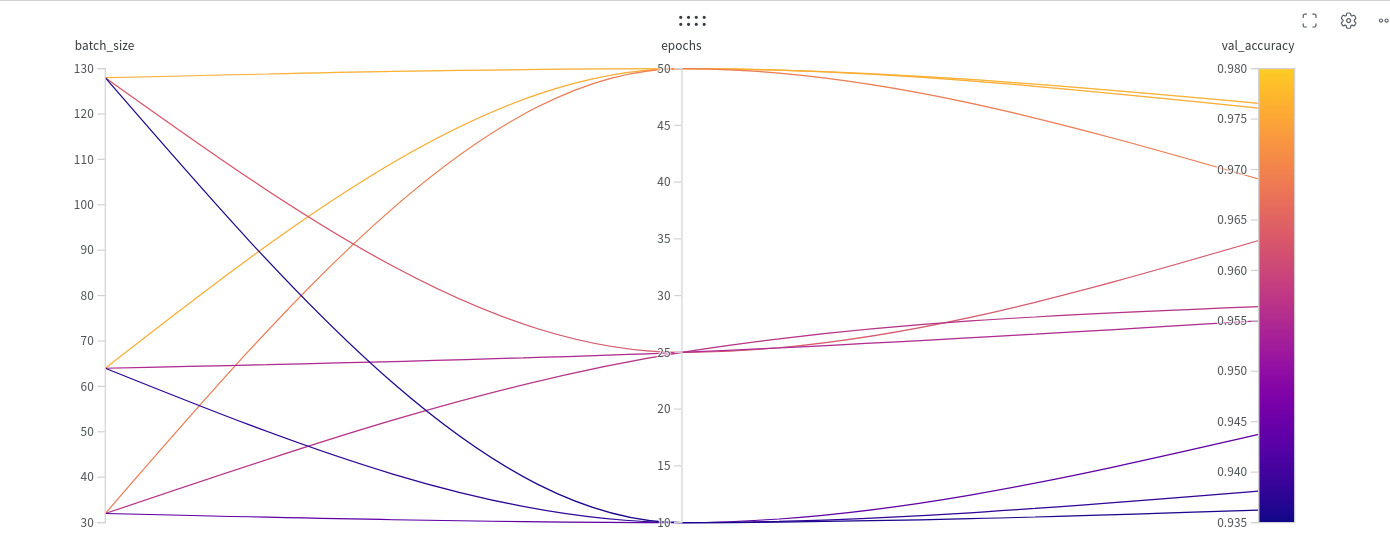

Seems like a batch size of 128 with 50 epochs is optimal fpr this problem

In [176]:
model = create_model()
history = model.fit(X_train_scaled, y_train_one_hot, epochs=50, batch_size=128, validation_data=(X_test_scaled, y_test_one_hot))

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4802 - loss: 1.5219 - val_accuracy: 0.8218 - val_loss: 0.5360
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7534 - loss: 0.7100 - val_accuracy: 0.8748 - val_loss: 0.3787
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8256 - loss: 0.5207 - val_accuracy: 0.8997 - val_loss: 0.2949
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8565 - loss: 0.4257 - val_accuracy: 0.9137 - val_loss: 0.2559
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8745 - loss: 0.3681 - val_accuracy: 0.9255 - val_loss: 0.2223
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8937 - loss: 0.3064 - val_accuracy: 0.9236 - val_loss: 0.2388
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9115 - loss: 0.2678 - val_accuracy: 0.9334 - val_loss: 0.2030
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9177 - loss: 0.2423 - val_accuracy: 0.9316 - v

In [178]:
y_pred_prob = model.predict(X_test_scaled)
y_pred_nn = np.argmax(y_pred_prob, axis=1)
report_mlp_tensor = classification_report(y_test_one_hot, y_pred_nn, target_names=list(one_hot.keys()))
reports['MLP_Tensorflow'] = report_mlp_tensor
print(f"**Classification report (MLP):**\n{report_mlp_tensor}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
**Classification report (MLP):**
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.97      0.97      0.97       414
       curva_direita_agressiva       0.98      1.00      0.99       387
      curva_esquerda_agressiva       0.99      1.00      0.99       365
          evento_nao_agressivo       0.96      0.93      0.95       480
              freada_agressiva       0.98      0.99      0.99       309
 troca_faixa_direita_agressiva       0.97      0.90      0.93        94
troca_faixa_esquerda_agressiva       0.85      0.94      0.89        84

                      accuracy                           0.97      2133
                     macro avg       0.96      0.96      0.96      2133
                  weighted avg       0.97      0.97      0.97      2133



# Comparing Results

In [182]:
def parse_classification_report(report):
    lines = report.split('\n')
    metrics = []
    accuracy = None
    for line in lines[2:-3]:  # Skip header and last two summary lines
        parts = line.split()
        if len(parts) < 4:
            continue
        class_name = parts[0]
        precision = float(parts[1])
        recall = float(parts[2])
        f1_score = float(parts[3])
        metrics.append((class_name, precision, recall, f1_score))
    
    # Extract accuracy from the summary line
    accuracy_line = lines[-2]  # Last second line for accuracy
    accuracy = float(accuracy_line.split()[-2])  # Accuracy is the second-to-last value

    return metrics, accuracy


In [205]:
def compare_reports(reports):
    # Assuming `reports` is a dictionary of reports from different models
    combined_df = []
    accuracies = {}

    # Iterate through the reports for different models
    for model, report in reports.items():
        print(f"**{model}:**")
        metrics, accuracy = parse_classification_report(report)
        # Create a DataFrame for each model's metrics
        df_model = pd.DataFrame(metrics, columns=["Class", "Precision", "Recall", "F1-Score"])
        df_model['Model'] = model
        combined_df.append(df_model)
        accuracies[model] = accuracy  # Store accuracy for the model

    # Concatenate all model DataFrames into a single DataFrame
    combined_df = pd.concat(combined_df, axis=0)

    # Melt the DataFrame to long format for plotting
    melted_df = combined_df.melt(id_vars=['Model', 'Class'], var_name="Metric", value_name="Score")

    # Create subplots for Precision, Recall, F1-Score, and Accuracy
    fig, axes = plt.subplots(len(reports), 1, figsize=(20, 20))

    # Plot Precision
    sns.barplot(x='Class', y='Score', hue='Model', data=melted_df[melted_df['Metric'] == 'Precision'], ax=axes[0])
    axes[0].set_title('Comparison of Models by Precision')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Precision')
    axes[0].set_ylim(0.9, 1)

    # Plot Recall
    sns.barplot(x='Class', y='Score', hue='Model', data=melted_df[melted_df['Metric'] == 'Recall'], ax=axes[1])
    axes[1].set_title('Comparison of Models by Recall')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Recall')
    axes[1].set_ylim(0.9, 1)

    # Plot F1-Score
    sns.barplot(x='Class', y='Score', hue='Model', data=melted_df[melted_df['Metric'] == 'F1-Score'], ax=axes[2])
    axes[2].set_title('Comparison of Models by F1-Score')
    axes[2].set_xlabel('Class')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_ylim(0.9, 1)

    # Plot Accuracy (this is a separate bar plot because accuracy is not per class)
    accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])
    sns.barplot(x='Model', y='Accuracy', data=accuracy_df, ax=axes[3])
    axes[3].set_title('Comparison of Models by Accuracy')
    axes[3].set_xlabel('Model')
    axes[3].set_ylabel('Accuracy')
    axes[3].set_ylim(0.9, 1)

    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()
    

**Random Forest:**
**SVC:**
**XGB:**
**MLP_Tensorflow:**


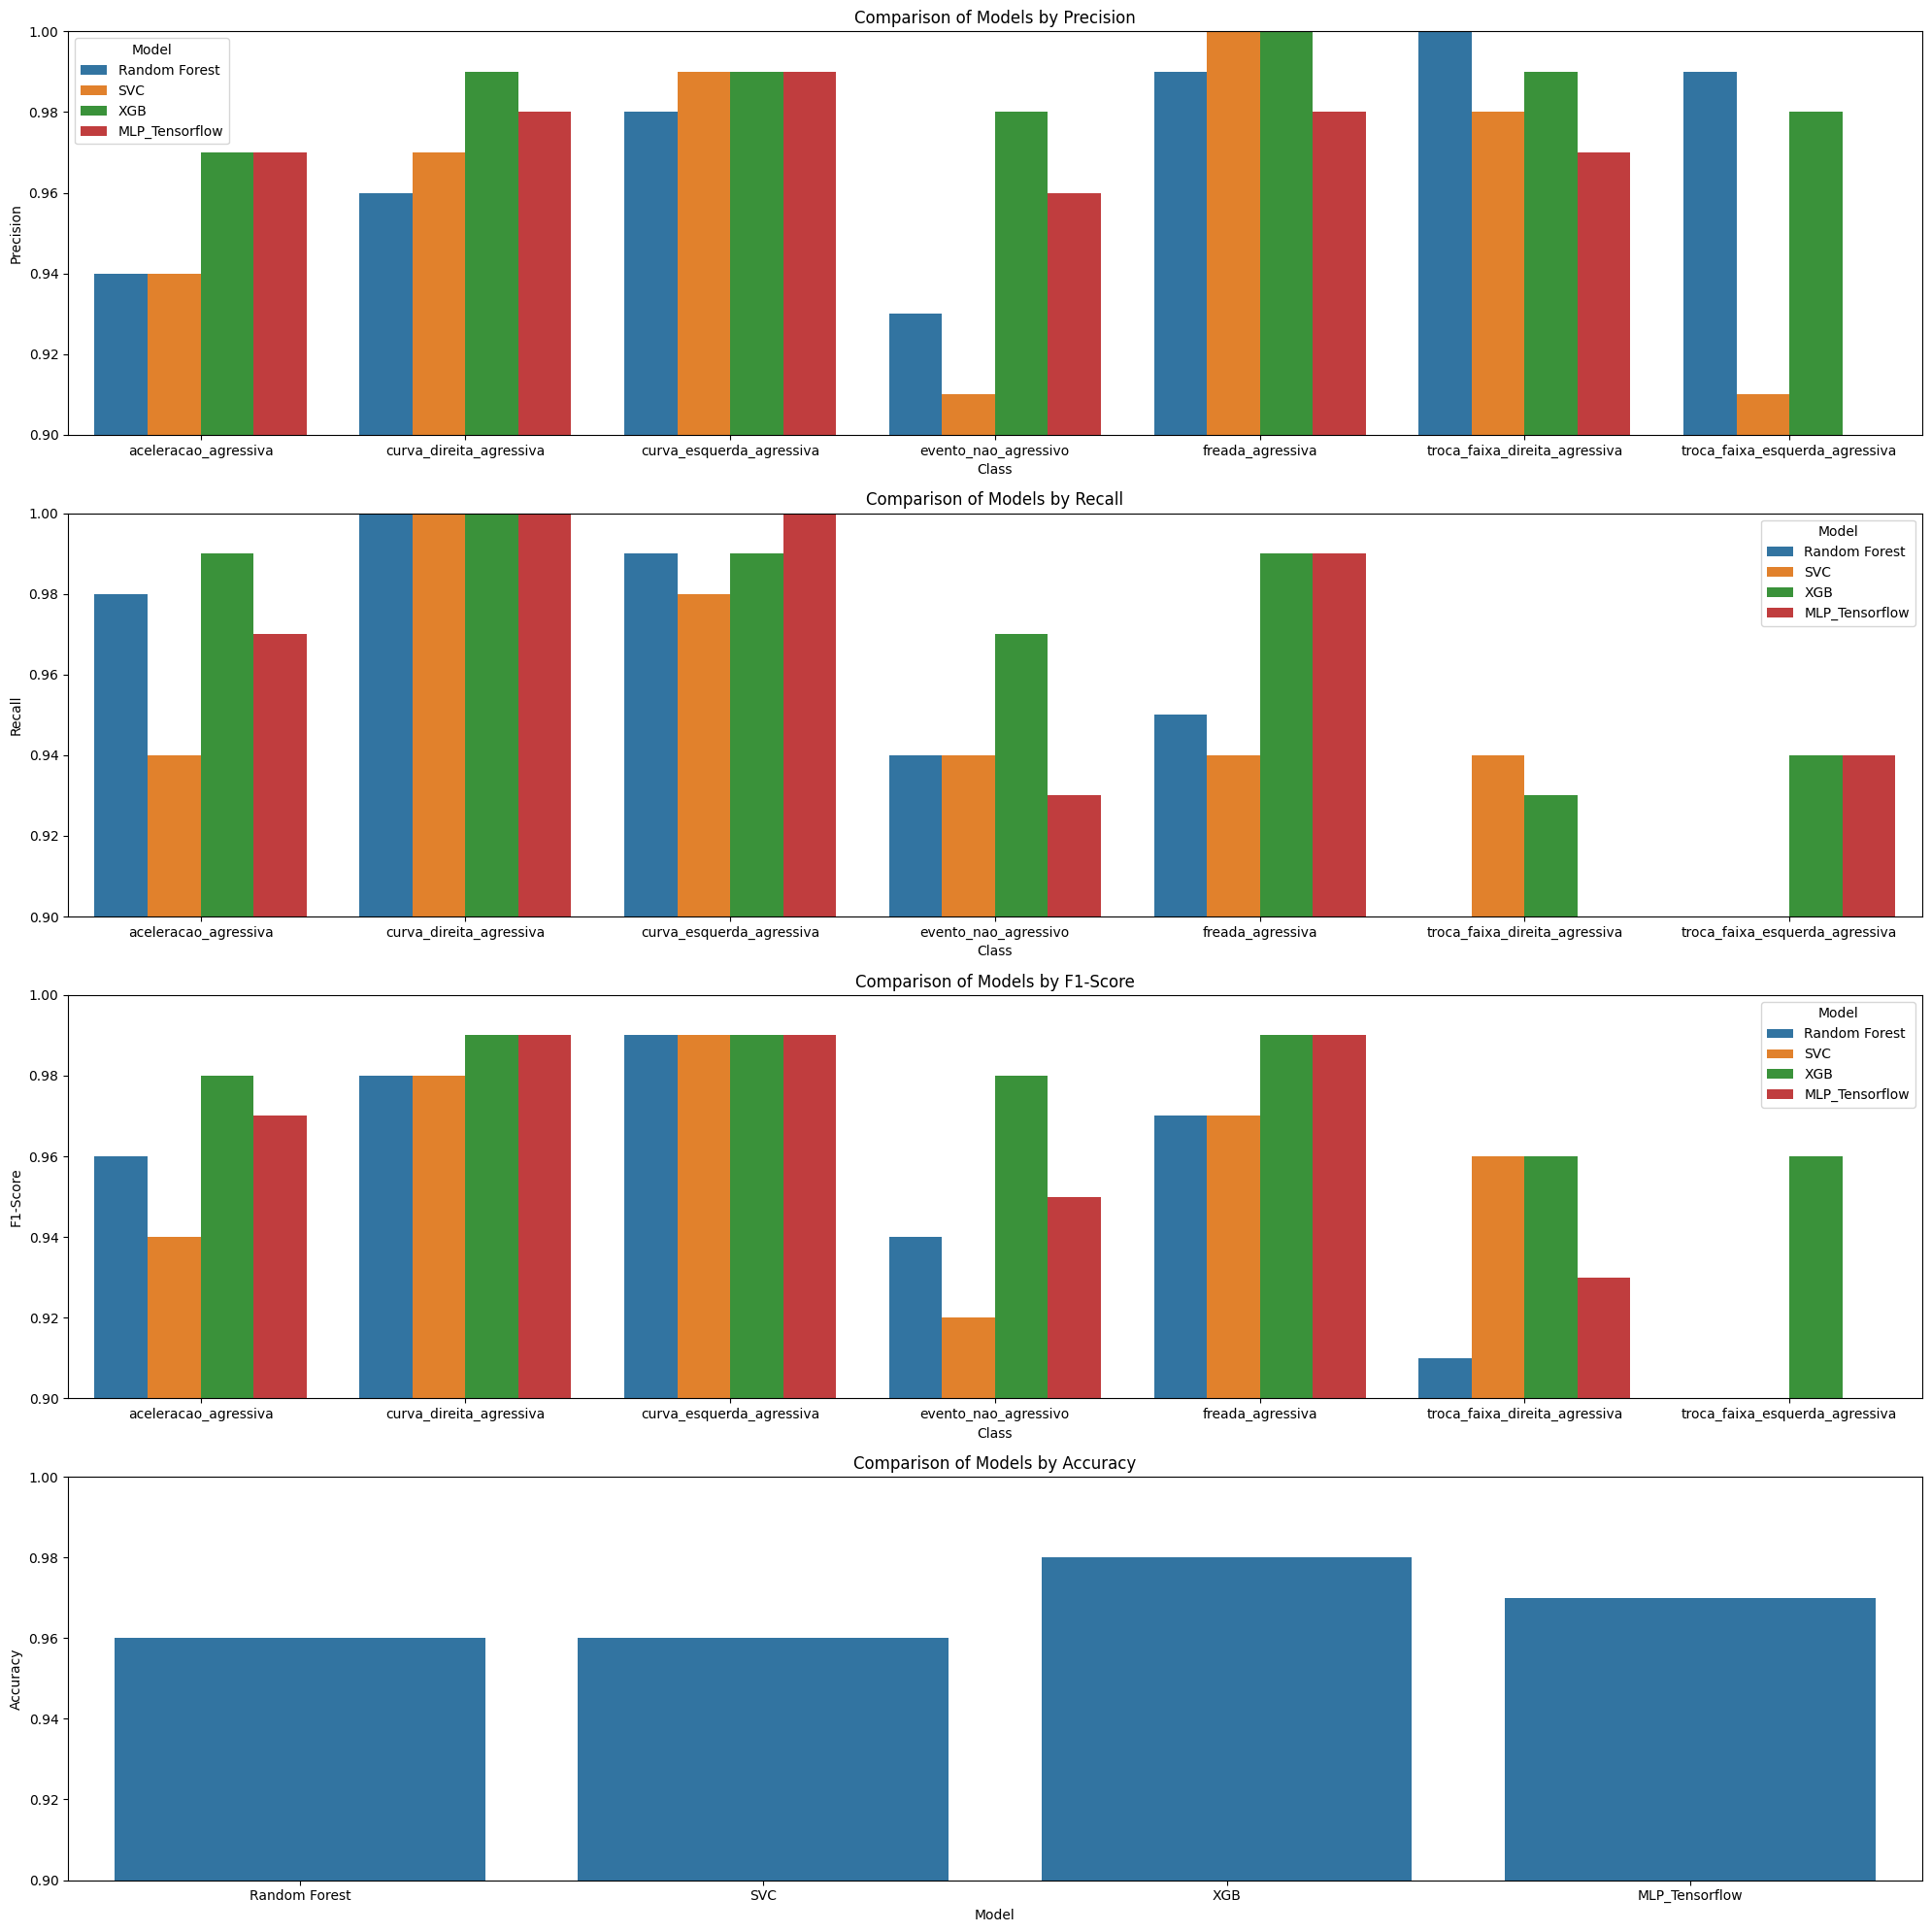

In [206]:
compare_reports(reports)